# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, imaging_type_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths), tissue type (labels), and imaging type columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_label_encoder:
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_label_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder and imaging type encoder
    le = train_dataset.get_label_encoder()
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [9]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [10]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        ax2.set_xlabel('Epoch')

# Model Definitions

In [11]:
class DenseNetWithImagingType(nn.Module):
    def __init__(self, base_model, num_classes=4, num_imaging_types=2, embedding_dim=16):
        super(DenseNetWithImagingType, self).__init__()
        self.base_model = base_model
        
        # Remove the original classifier
        num_features = base_model.classifier.in_features
        base_model.classifier = nn.Identity()
        
        # Imaging type embedding
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that takes both image features and imaging type
        self.classifier = nn.Linear(num_features + embedding_dim, num_classes)
        
    def forward(self, x, imaging_type):
        # Get image features
        image_features = self.base_model(x)
        
        # Get imaging type embedding
        imaging_embedding = self.imaging_type_embedding(imaging_type)
        
        # Concatenate features
        combined_features = torch.cat([image_features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        return output

def create_densenet_model(architecture='121', num_classes=4, num_imaging_types=2, pretrained=True):
    """Create DenseNet model with imaging type input for multi-class classification
    
    Supported architectures: '121', '201'
    """
    if architecture == '121':
        base_model = models.densenet121(pretrained=pretrained)
    elif architecture == '201':
        base_model = models.densenet201(pretrained=pretrained)
    else:
        raise ValueError("Architecture must be '121' or '201'")
    
    # Wrap with imaging type support
    model = DenseNetWithImagingType(base_model, num_classes=num_classes, num_imaging_types=num_imaging_types)
    
    return model

# Configure GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [13]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [14]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train DenseNet-121

Training DenseNet-121 with Imaging Type
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30.8M/30.8M [00:00<00:00, 197MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.39it/s, Loss=0.5452, Acc=0.8117]


Train Loss: 0.5452 Acc: 0.8117 Macro-F1: 0.7617


Val : 100%|██████████| 10/10 [00:01<00:00,  6.44it/s, Loss=0.2366, Acc=0.9013]


Val Loss: 0.2366 Acc: 0.9013 Macro-F1: 0.8744
✓ New best model saved with validation macro-F1: 0.8744

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.19it/s, Loss=0.1920, Acc=0.9424]


Train Loss: 0.1920 Acc: 0.9424 Macro-F1: 0.9222


Val : 100%|██████████| 10/10 [00:01<00:00,  9.31it/s, Loss=0.0670, Acc=0.9737]


Val Loss: 0.0670 Acc: 0.9737 Macro-F1: 0.9694
✓ New best model saved with validation macro-F1: 0.9694

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.19it/s, Loss=0.1376, Acc=0.9589]


Train Loss: 0.1376 Acc: 0.9589 Macro-F1: 0.9462


Val : 100%|██████████| 10/10 [00:01<00:00,  9.18it/s, Loss=0.3487, Acc=0.8651]


Val Loss: 0.3487 Acc: 0.8651 Macro-F1: 0.8387

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.20it/s, Loss=0.1142, Acc=0.9605]


Train Loss: 0.1142 Acc: 0.9605 Macro-F1: 0.9487


Val : 100%|██████████| 10/10 [00:01<00:00,  8.23it/s, Loss=0.0684, Acc=0.9803]


Val Loss: 0.0684 Acc: 0.9803 Macro-F1: 0.9798
✓ New best model saved with validation macro-F1: 0.9798

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.04it/s, Loss=0.0798, Acc=0.9753]


Train Loss: 0.0798 Acc: 0.9753 Macro-F1: 0.9700


Val : 100%|██████████| 10/10 [00:01<00:00,  8.88it/s, Loss=0.1741, Acc=0.9342]


Val Loss: 0.1741 Acc: 0.9342 Macro-F1: 0.9216

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.13it/s, Loss=0.2113, Acc=0.9309]


Train Loss: 0.2113 Acc: 0.9309 Macro-F1: 0.9089


Val : 100%|██████████| 10/10 [00:01<00:00,  9.03it/s, Loss=0.3959, Acc=0.8783]


Val Loss: 0.3959 Acc: 0.8783 Macro-F1: 0.8304

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.19it/s, Loss=0.1489, Acc=0.9539]


Train Loss: 0.1489 Acc: 0.9539 Macro-F1: 0.9370


Val : 100%|██████████| 10/10 [00:01<00:00,  8.87it/s, Loss=0.1249, Acc=0.9671]


Val Loss: 0.1249 Acc: 0.9671 Macro-F1: 0.9652

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.19it/s, Loss=0.0515, Acc=0.9868]


Train Loss: 0.0515 Acc: 0.9868 Macro-F1: 0.9892


Val : 100%|██████████| 10/10 [00:01<00:00,  9.18it/s, Loss=0.0375, Acc=0.9901]


Val Loss: 0.0375 Acc: 0.9901 Macro-F1: 0.9881
✓ New best model saved with validation macro-F1: 0.9881

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.19it/s, Loss=0.0288, Acc=0.9942]


Train Loss: 0.0288 Acc: 0.9942 Macro-F1: 0.9930


Val : 100%|██████████| 10/10 [00:01<00:00,  9.07it/s, Loss=0.0268, Acc=0.9934]


Val Loss: 0.0268 Acc: 0.9934 Macro-F1: 0.9907
✓ New best model saved with validation macro-F1: 0.9907

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.17it/s, Loss=0.0165, Acc=0.9959]


Train Loss: 0.0165 Acc: 0.9959 Macro-F1: 0.9945


Val : 100%|██████████| 10/10 [00:01<00:00,  8.41it/s, Loss=0.0235, Acc=0.9934]


Val Loss: 0.0235 Acc: 0.9934 Macro-F1: 0.9907

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.18it/s, Loss=0.0115, Acc=0.9967]


Train Loss: 0.0115 Acc: 0.9967 Macro-F1: 0.9973


Val : 100%|██████████| 10/10 [00:01<00:00,  8.16it/s, Loss=0.0207, Acc=0.9934]


Val Loss: 0.0207 Acc: 0.9934 Macro-F1: 0.9907

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.18it/s, Loss=0.0123, Acc=0.9975]


Train Loss: 0.0123 Acc: 0.9975 Macro-F1: 0.9981


Val : 100%|██████████| 10/10 [00:01<00:00,  8.97it/s, Loss=0.0218, Acc=0.9901]


Val Loss: 0.0218 Acc: 0.9901 Macro-F1: 0.9881

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.11it/s, Loss=0.0089, Acc=1.0000]


Train Loss: 0.0089 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.08it/s, Loss=0.0163, Acc=0.9934]


Val Loss: 0.0163 Acc: 0.9934 Macro-F1: 0.9907

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.18it/s, Loss=0.0079, Acc=1.0000]


Train Loss: 0.0079 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  8.95it/s, Loss=0.0127, Acc=0.9967]


Val Loss: 0.0127 Acc: 0.9967 Macro-F1: 0.9974
✓ New best model saved with validation macro-F1: 0.9974

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.19it/s, Loss=0.0070, Acc=1.0000]


Train Loss: 0.0070 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.13it/s, Loss=0.0147, Acc=0.9934]


Val Loss: 0.0147 Acc: 0.9934 Macro-F1: 0.9907

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.20it/s, Loss=0.0075, Acc=0.9984]


Train Loss: 0.0075 Acc: 0.9984 Macro-F1: 0.9986


Val : 100%|██████████| 10/10 [00:01<00:00,  8.95it/s, Loss=0.0146, Acc=0.9934]


Val Loss: 0.0146 Acc: 0.9934 Macro-F1: 0.9907

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.19it/s, Loss=0.0067, Acc=0.9992]


Train Loss: 0.0067 Acc: 0.9992 Macro-F1: 0.9994


Val : 100%|██████████| 10/10 [00:01<00:00,  8.67it/s, Loss=0.0125, Acc=0.9967]


Val Loss: 0.0125 Acc: 0.9967 Macro-F1: 0.9974

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.20it/s, Loss=0.0068, Acc=0.9992]


Train Loss: 0.0068 Acc: 0.9992 Macro-F1: 0.9993


Val : 100%|██████████| 10/10 [00:01<00:00,  8.35it/s, Loss=0.0126, Acc=0.9934]


Val Loss: 0.0126 Acc: 0.9934 Macro-F1: 0.9907

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.20it/s, Loss=0.0060, Acc=1.0000]


Train Loss: 0.0060 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  8.72it/s, Loss=0.0120, Acc=0.9934]


Val Loss: 0.0120 Acc: 0.9934 Macro-F1: 0.9907
Early stopping triggered after 19 epochs
Training complete in 2m 44s
Best validation macro-F1: 0.9974
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


Test Accuracy: 48.68%
Test Loss: 1.8865

Classification Report:
              precision    recall  f1-score   support

         HGC       0.53      0.53      0.53        74
         LGC       0.23      0.13      0.17        53
         NST       0.71      0.68      0.69        37
         NTL       0.42      0.84      0.56        25

    accuracy                           0.49       189
   macro avg       0.47      0.54      0.49       189
weighted avg       0.47      0.49      0.46       189


Confusion Matrix:
[[39 21  9  5]
 [31  7  0 15]
 [ 2  1 25  9]
 [ 1  2  1 21]]

ROC-AUC Scores:
Macro-average AUC: 0.7100
Micro-average AUC: 0.7063
HGC AUC: 0.6404
LGC AUC: 0.4498
NST AUC: 0.8832
NTL AUC: 0.8666


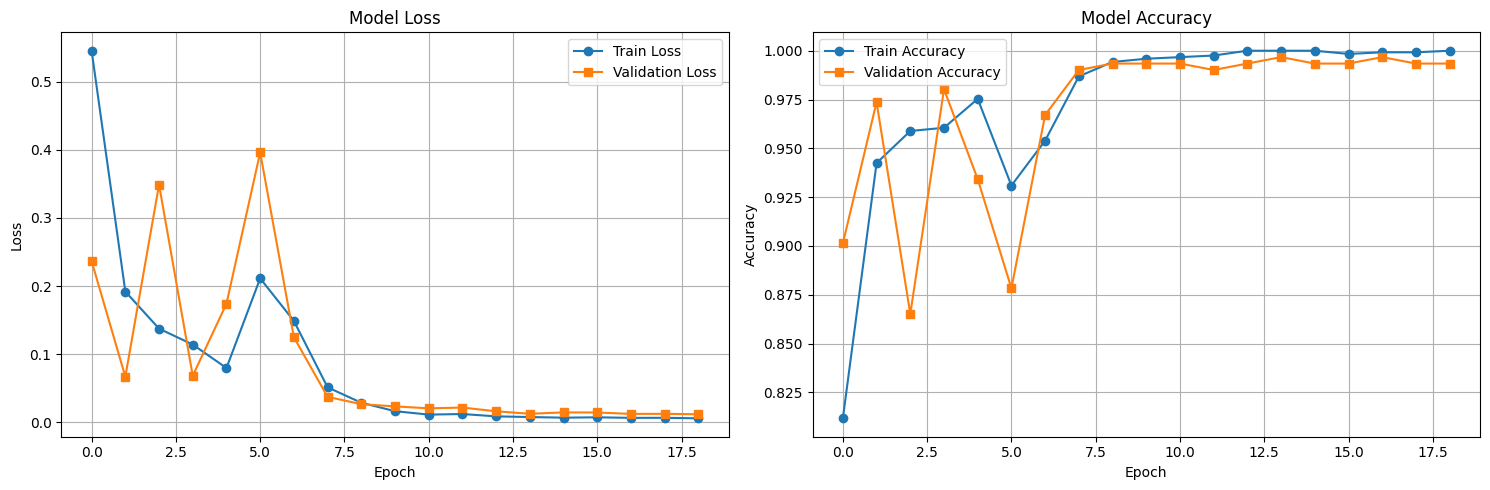

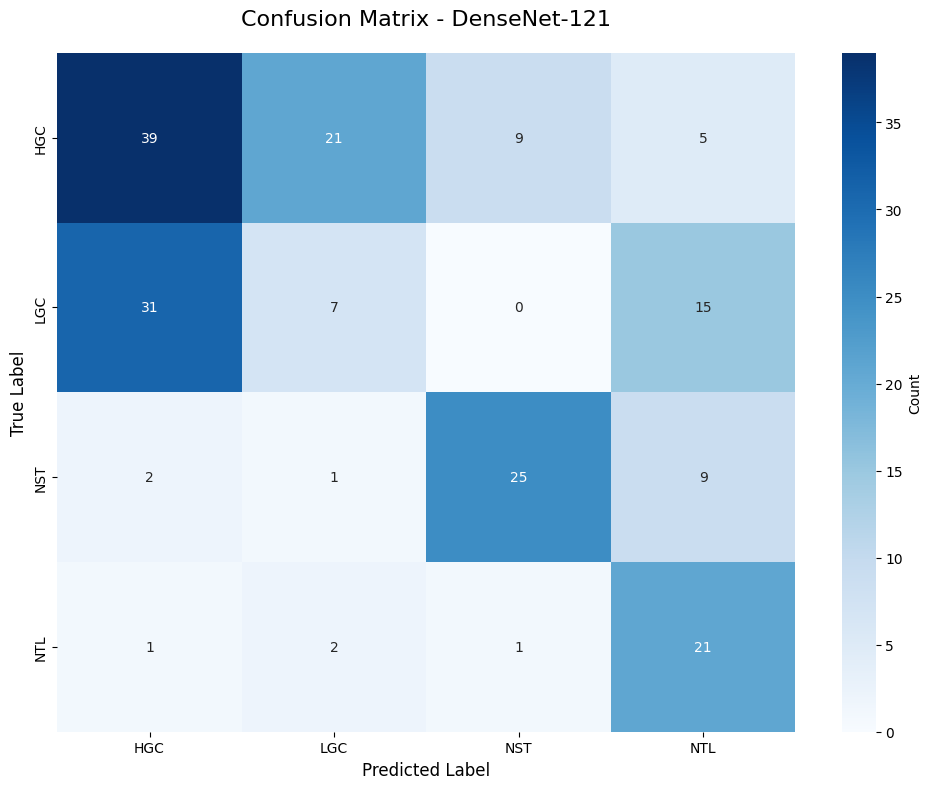

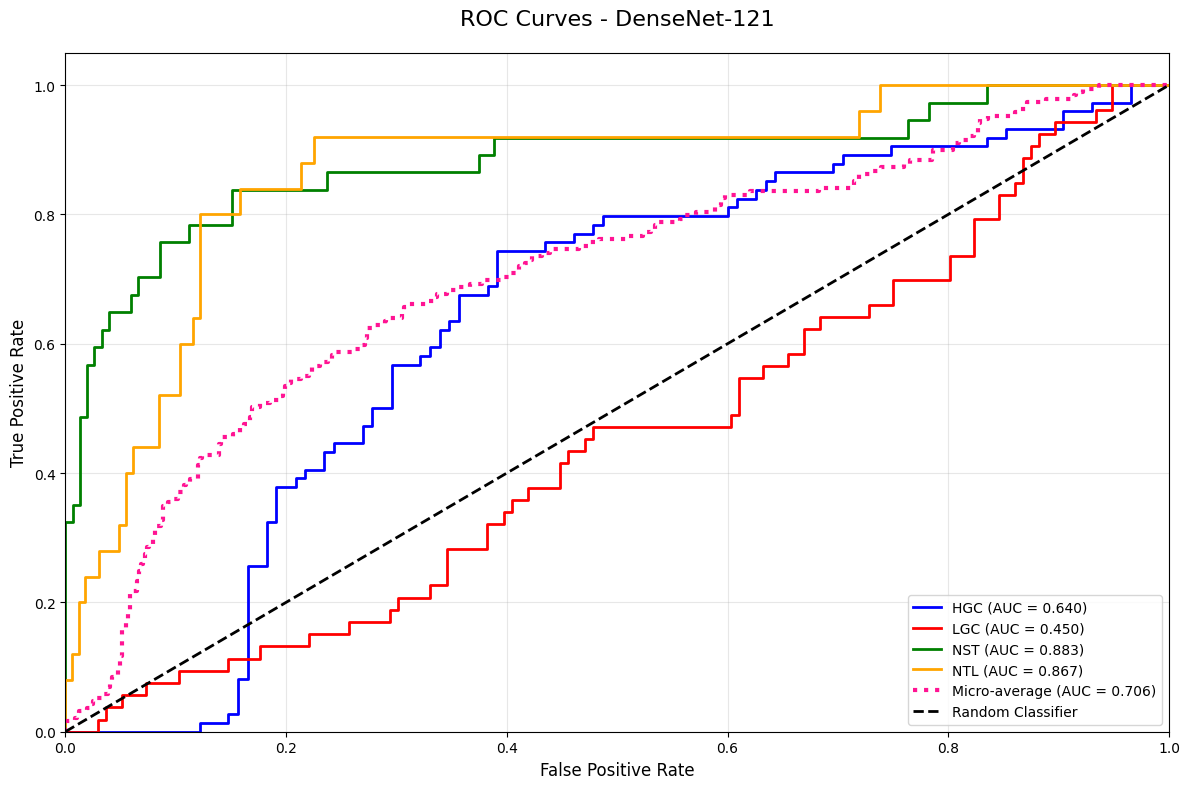


DenseNet-121 training and evaluation complete!


In [15]:
print("=" * 80)
print("Training DenseNet-121 with Imaging Type")
print("=" * 80)

# Create model
densenet121 = create_densenet_model(architecture='121', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_121 = ModelTrainer(densenet121, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_121 = trainer_121.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="DenseNet-121_with_ImagingType")

# Plot training history
trainer_121.plot_training_history(save_path='densenet121_training_history.png')

# Evaluate model
results_121 = trainer_121.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_121['confusion_matrix'], class_names, 'DenseNet-121',
                      save_path='densenet121_confusion_matrix.png')

# Plot ROC curves
roc_auc_121 = plot_roc_curves(results_121['labels'], results_121['probabilities'], class_names, 'DenseNet-121',
                              save_path='densenet121_roc_curves.png')
# Store results
results_121['model_name'] = 'DenseNet-121'
results_121['roc_auc'] = roc_auc_121
all_results.append(results_121)

print("\nDenseNet-121 training and evaluation complete!")

## Train DenseNet-201

Training DenseNet-201 with Imaging Type


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


100%|██████████| 77.4M/77.4M [00:00<00:00, 188MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.25it/s, Loss=0.6260, Acc=0.7969]


Train Loss: 0.6260 Acc: 0.7969 Macro-F1: 0.7425


Val : 100%|██████████| 10/10 [00:01<00:00,  6.95it/s, Loss=1.2541, Acc=0.7072]


Val Loss: 1.2541 Acc: 0.7072 Macro-F1: 0.7172
✓ New best model saved with validation macro-F1: 0.7172

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.24it/s, Loss=0.2711, Acc=0.9112]


Train Loss: 0.2711 Acc: 0.9112 Macro-F1: 0.8833


Val : 100%|██████████| 10/10 [00:01<00:00,  7.15it/s, Loss=1.1049, Acc=0.7467]


Val Loss: 1.1049 Acc: 0.7467 Macro-F1: 0.7067

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.31it/s, Loss=0.2094, Acc=0.9334]


Train Loss: 0.2094 Acc: 0.9334 Macro-F1: 0.9153


Val : 100%|██████████| 10/10 [00:01<00:00,  7.17it/s, Loss=0.6786, Acc=0.7467]


Val Loss: 0.6786 Acc: 0.7467 Macro-F1: 0.7149

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.1391, Acc=0.9507]


Train Loss: 0.1391 Acc: 0.9507 Macro-F1: 0.9387


Val : 100%|██████████| 10/10 [00:01<00:00,  7.07it/s, Loss=0.1167, Acc=0.9803]


Val Loss: 0.1167 Acc: 0.9803 Macro-F1: 0.9841
✓ New best model saved with validation macro-F1: 0.9841

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.0748, Acc=0.9794]


Train Loss: 0.0748 Acc: 0.9794 Macro-F1: 0.9745


Val : 100%|██████████| 10/10 [00:01<00:00,  7.09it/s, Loss=0.0875, Acc=0.9704]


Val Loss: 0.0875 Acc: 0.9704 Macro-F1: 0.9710

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.2122, Acc=0.9391]


Train Loss: 0.2122 Acc: 0.9391 Macro-F1: 0.9186


Val : 100%|██████████| 10/10 [00:01<00:00,  6.83it/s, Loss=1.0383, Acc=0.7763]


Val Loss: 1.0383 Acc: 0.7763 Macro-F1: 0.7290

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.0889, Acc=0.9737]


Train Loss: 0.0889 Acc: 0.9737 Macro-F1: 0.9687


Val : 100%|██████████| 10/10 [00:01<00:00,  7.21it/s, Loss=0.0927, Acc=0.9671]


Val Loss: 0.0927 Acc: 0.9671 Macro-F1: 0.9645

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.0415, Acc=0.9868]


Train Loss: 0.0415 Acc: 0.9868 Macro-F1: 0.9858


Val : 100%|██████████| 10/10 [00:01<00:00,  7.05it/s, Loss=0.0304, Acc=0.9901]


Val Loss: 0.0304 Acc: 0.9901 Macro-F1: 0.9919
✓ New best model saved with validation macro-F1: 0.9919

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.31it/s, Loss=0.0181, Acc=0.9951]


Train Loss: 0.0181 Acc: 0.9951 Macro-F1: 0.9960


Val : 100%|██████████| 10/10 [00:01<00:00,  7.11it/s, Loss=0.0189, Acc=0.9934]


Val Loss: 0.0189 Acc: 0.9934 Macro-F1: 0.9945
✓ New best model saved with validation macro-F1: 0.9945

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.0178, Acc=0.9951]


Train Loss: 0.0178 Acc: 0.9951 Macro-F1: 0.9935


Val : 100%|██████████| 10/10 [00:01<00:00,  7.15it/s, Loss=0.0177, Acc=0.9934]


Val Loss: 0.0177 Acc: 0.9934 Macro-F1: 0.9945

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.31it/s, Loss=0.0129, Acc=0.9951]


Train Loss: 0.0129 Acc: 0.9951 Macro-F1: 0.9958


Val : 100%|██████████| 10/10 [00:01<00:00,  7.03it/s, Loss=0.0118, Acc=0.9967]


Val Loss: 0.0118 Acc: 0.9967 Macro-F1: 0.9974
✓ New best model saved with validation macro-F1: 0.9974

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.0098, Acc=0.9975]


Train Loss: 0.0098 Acc: 0.9975 Macro-F1: 0.9980


Val : 100%|██████████| 10/10 [00:01<00:00,  7.09it/s, Loss=0.0105, Acc=0.9934]


Val Loss: 0.0105 Acc: 0.9934 Macro-F1: 0.9945

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.0067, Acc=1.0000]


Train Loss: 0.0067 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  7.17it/s, Loss=0.0117, Acc=0.9934]


Val Loss: 0.0117 Acc: 0.9934 Macro-F1: 0.9945

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.0084, Acc=0.9984]


Train Loss: 0.0084 Acc: 0.9984 Macro-F1: 0.9988


Val : 100%|██████████| 10/10 [00:01<00:00,  7.12it/s, Loss=0.0105, Acc=0.9934]


Val Loss: 0.0105 Acc: 0.9934 Macro-F1: 0.9945

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.0064, Acc=0.9992]


Train Loss: 0.0064 Acc: 0.9992 Macro-F1: 0.9994


Val : 100%|██████████| 10/10 [00:01<00:00,  7.16it/s, Loss=0.0089, Acc=0.9967]


Val Loss: 0.0089 Acc: 0.9967 Macro-F1: 0.9974

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.30it/s, Loss=0.0053, Acc=1.0000]


Train Loss: 0.0053 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  7.17it/s, Loss=0.0096, Acc=0.9967]


Val Loss: 0.0096 Acc: 0.9967 Macro-F1: 0.9974
Early stopping triggered after 16 epochs
Training complete in 3m 29s
Best validation macro-F1: 0.9974
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


Test Accuracy: 51.85%
Test Loss: 1.6811

Classification Report:
              precision    recall  f1-score   support

         HGC       0.60      0.35      0.44        74
         LGC       0.44      0.45      0.44        53
         NST       0.80      0.76      0.78        37
         NTL       0.36      0.80      0.49        25

    accuracy                           0.52       189
   macro avg       0.55      0.59      0.54       189
weighted avg       0.56      0.52      0.52       189


Confusion Matrix:
[[26 30  2 16]
 [17 24  0 12]
 [ 0  1 28  8]
 [ 0  0  5 20]]

ROC-AUC Scores:
Macro-average AUC: 0.7626
Micro-average AUC: 0.7575
HGC AUC: 0.6382
LGC AUC: 0.6856
NST AUC: 0.8931
NTL AUC: 0.8334


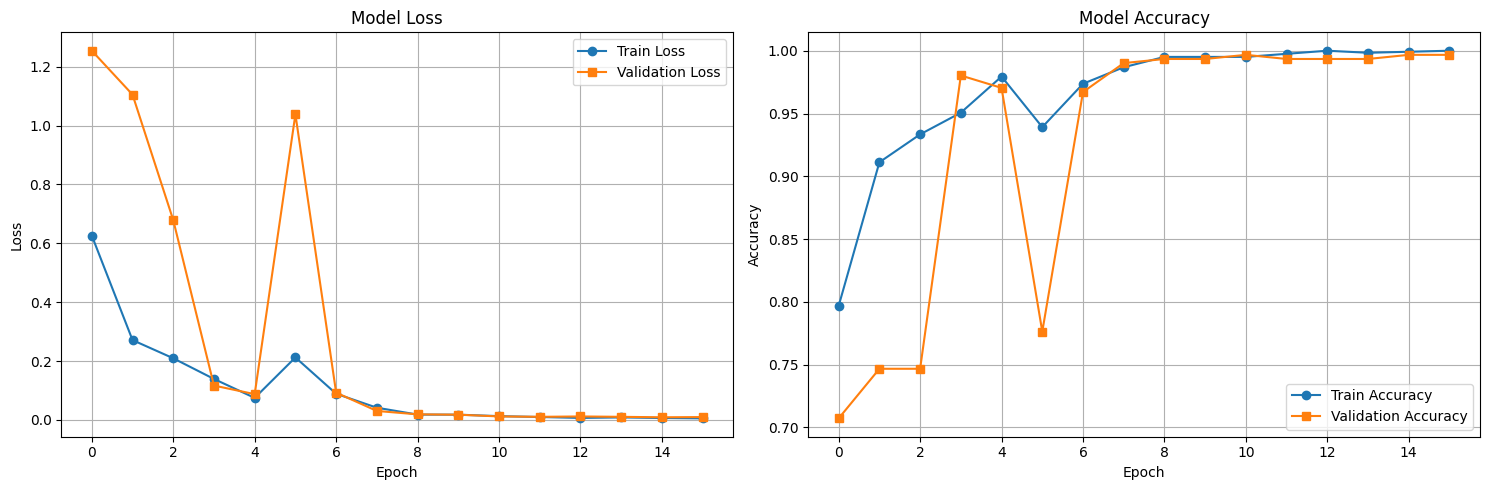

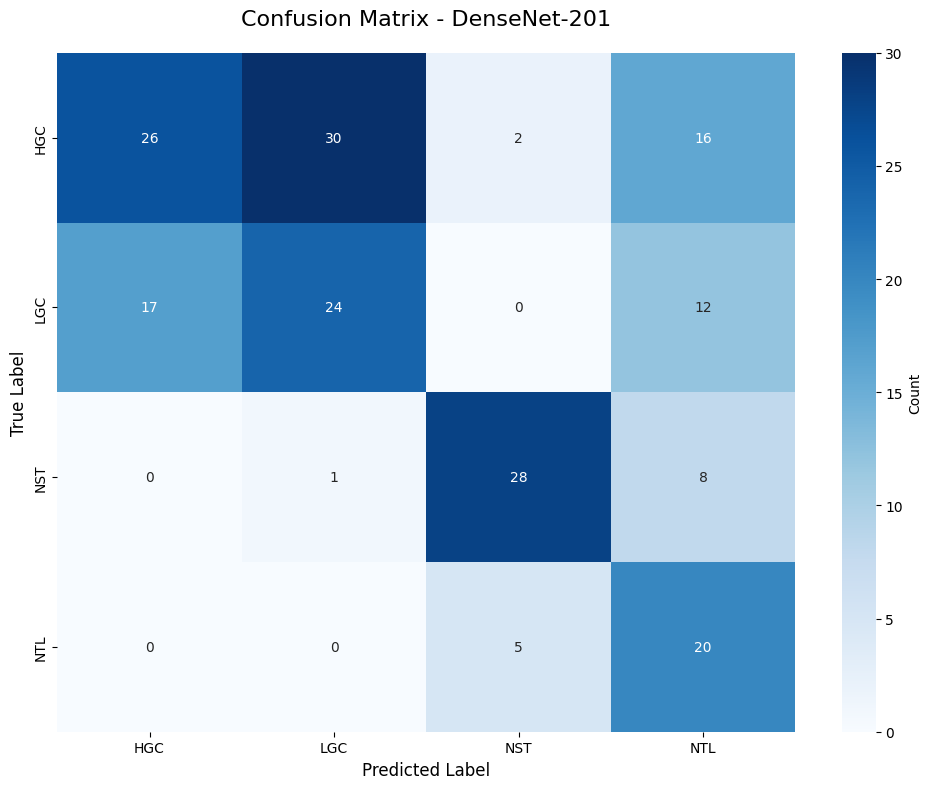

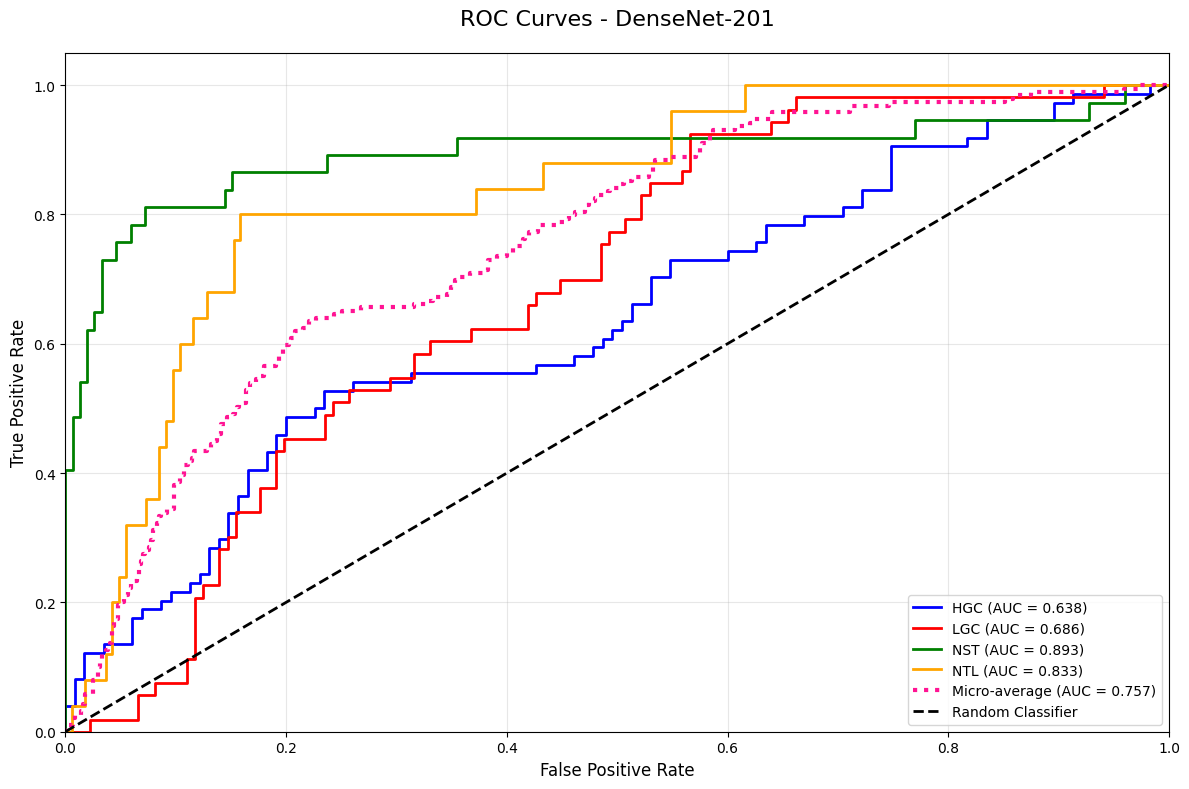


DenseNet-201 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training DenseNet-201 with Imaging Type")
print("=" * 80)

# Create model
densenet201 = create_densenet_model(architecture='201', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_201 = ModelTrainer(densenet201, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_201 = trainer_201.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="DenseNet-201_with_ImagingType")

# Plot training history
trainer_201.plot_training_history(save_path='densenet201_training_history.png')

# Evaluate model
results_201 = trainer_201.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_201['confusion_matrix'], class_names, 'DenseNet-201',
                      save_path='densenet201_confusion_matrix.png')

# Plot ROC curves
roc_auc_201 = plot_roc_curves(results_201['labels'], results_201['probabilities'], class_names, 'DenseNet-201',
                               save_path='Densenet201_roc_curves.png')
# Store results
results_201['model_name'] = 'DenseNet-201'
results_201['roc_auc'] = roc_auc_201
all_results.append(results_201)

print("\nDenseNet-201 training and evaluation complete!")

# Save All Metrics to CSV

In [17]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'DenseNet-121_201.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())



Metrics saved to: DenseNet-121_201.csv

Metrics Summary:
          Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  DenseNet-121         48.677249      1.886461             0.473585          0.543695      0.487931                0.467887             0.486772         0.464514       0.534247    0.527027  0.530612         74.0       0.225806    0.132075  0.166667         53.0       0.714286    0.675676  0.694444         37.0       0.420000        0.84  0.560000         25.0   0.709991   0.706298  0.640423  0.449778  0.883179  0.866585      0.640423   